# Final Project Baseline: House Prices- Advanced Regression Techniques
### Author: Radia Abdul Wahab, Parham Motameni, Jun Qian
### Date: Fall 2021
### Course: w207 Machine Learning







## Supplementary Notebook for Various Linear Regression Models, Hyperparameter tuning and RMSE assessment. 

In [66]:
# This tells matplotlib not to try opening a new window for each plot.
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import time
import random
import scipy.io as sio
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# sklearn
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR
from sklearn.feature_selection import RFE


# internal modules
from base_regressor_plot import BaseRegressorPlot
from configurations import args
from data_loader import DataLoader
from elastic_net_regressor import ElasticNetRegressor
from decision_tree_regressor import DecisionTreeRegressor
from lasso_regressor import LassoRegressor
from linear_regressor import LinearRegressor
from random_forest_regressor import RandomForestRegressor
from ridge_regressor import RidgeRegressor
#from neuralnetwork import create_nn_regressor

%matplotlib inline


warnings.filterwarnings('ignore')





In [67]:
# download data file if it is not ready
data_file = Path(args.data_path)
if data_file.is_file():
    print("Datafile is already loaded.")
else:
    !curl -L "https://drive.google.com/uc?export=download&id=1ortEJfmlpt9-dbg5f6cTDt5nicswf5wT" > 'test.csv'
    !curl -L "https://drive.google.com/uc?export=download&id=1EG5jP5RDEIsNAMaF2m42KOyz-ZVjC8wS" > 'train.csv'
data_loader = DataLoader(args)
df = data_loader.df

Datafile is already loaded.


In [68]:
# lock the seed to have repeatable results
random.seed(100)

## Taking a look at what the features are
Additionally reviewed the data_description.txt file. The column names and the names on the file correspond accurately

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1456 non-null   int64  
 1   MSSubClass     1456 non-null   int64  
 2   MSZoning       1456 non-null   object 
 3   LotFrontage    1197 non-null   float64
 4   LotArea        1456 non-null   int64  
 5   Street         1456 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1456 non-null   object 
 8   LandContour    1456 non-null   object 
 9   Utilities      1456 non-null   object 
 10  LotConfig      1456 non-null   object 
 11  LandSlope      1456 non-null   object 
 12  Neighborhood   1456 non-null   object 
 13  Condition1     1456 non-null   object 
 14  Condition2     1456 non-null   object 
 15  BldgType       1456 non-null   object 
 16  HouseStyle     1456 non-null   object 
 17  OverallQual    1456 non-null   int64  
 18  OverallC

## Check whether there are variables with significant missing values. 

It looks like PoolQC , MiscFeature, Alley, Fence, FireplaceQu,LotFrontage have substantial missing values. 

Looking closer into the descriptions of these variables, we find most NA actually means the house does not have such feature. For example, if a value is missing from PoolQC, most likely that house doesn't even have a pool.

So we looked at the variables, to see which ones will fall under this category and fill it with "NonExist" as a distinct category.

In [70]:
missing=df.isnull().sum().sort_values(ascending=False).head(20)
missing

missing = missing[missing > 0]
percent_missing = missing * 100 / df.shape[0]
pd.concat([missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage Missing']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage Missing
PoolQC,1451,99.656593
MiscFeature,1402,96.291209
Alley,1365,93.750000
Fence,1176,80.769231
FireplaceQu,690,47.390110
LotFrontage,259,17.788462
GarageYrBlt,81,5.563187
GarageQual,81,5.563187
GarageFinish,81,5.563187
GarageType,81,5.563187


In [71]:
# Fill missing value of 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu' as NonExist. Leave LotFrontage for further investigation
df[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']]=df[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']].fillna('NonExist')
missing_with_replace=df.isnull().sum().sort_values(ascending=False).head(20)
missing_with_replace


missing_with_replace = missing_with_replace[missing_with_replace > 0]
percent_missing = missing_with_replace * 100 / df.shape[0]
pd.concat([missing_with_replace, percent_missing], axis=1, 
          keys=['Missing Values After filling Non_Exist', 'Percentage Missing']).\
          sort_values(by="Missing Values After filling Non_Exist", ascending=False)

,Missing Values After filling Non_Exist,Percentage Missing
LotFrontage,259,17.788462
GarageYrBlt,81,5.563187
GarageCond,81,5.563187
GarageType,81,5.563187
GarageFinish,81,5.563187
GarageQual,81,5.563187
BsmtExposure,38,2.609890
BsmtFinType2,38,2.609890
BsmtFinType1,37,2.541209
BsmtCond,37,2.541209


### Where we decided to leave it

We replaced "Pool, Misc Features, Alley, Fence and Fireplace". Those seemed obvious and missing values % was very high. 

However, we were on the fence (no pun intended) on the Lot Frontage. So we replaced with "NoLotFrontage"

The next top of the residual missing values were all related to Garage (GarageYrBlt, GarageCond, GarageType, GarageFinish, GarageQual). All of them had the same number of missing values. And reviewing the data description it seems to us that these 81 houses did not have a garage. So we replaced them with "NoGarage"

Same for NoBasement and NoMassVnr.

For the first round we decide to keep rest as is.

In [72]:
# Create train, dev, test datasets

# split data into Test and train
X_train, X_test, y_train, y_test = train_test_split(
    data_loader.df_X, data_loader.df_y, test_size= 0.10, random_state=1)

print(len(X_train),len( X_test))

# TODO split more to dev set if needed!

"""
train_ratio = 0.90
validation_ratio = 0.05
test_ratio = 0.05

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = test_ratio/(test_ratio + validation_ratio)) 

print(len(X_train), len(X_val),len( X_test))

"""

1310 146


'\ntrain_ratio = 0.90\nvalidation_ratio = 0.05\ntest_ratio = 0.05\n\nX_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = test_ratio/(test_ratio + validation_ratio)) \n\nprint(len(X_train), len(X_val),len( X_test))\n\n'

## Initial Look at the data:

In [73]:
print(f'X_train size: {X_train.shape}, X_test size: {X_test.shape}')
print(f'y_train size: {y_train.shape}, y_test size: {y_test.shape}')
X_train.head()

X_train size: (1310, 79), X_test size: (146, 79)
y_train size: (1310, 1), y_test size: (146, 1)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
498,20,RL,65.0,7800,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,6,2009,WD,Normal
721,120,RM,NaN,4426,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
177,50,RL,NaN,13650,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
585,20,RL,88.0,11443,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2006,New,Partial
1394,120,RL,53.0,4045,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,10,2006,New,Partial


Above result shows that
1.  The **train** set has **1314** records (1314 labelled houses)
2.  The **test** set has **146 long** records (146 labelled houses)
3.  Each house has **79 features**. 
4.  Features are a mix of **nominal, ordinal, and categorical**
5.  We will have to be cognisant of the different data types for our assessments

## Analysis on SalePrice
#### Confirming whether our Target Variable is Normally Distributed

Text(0.5, 1.0, 'Sale Price Normality Evaluation')

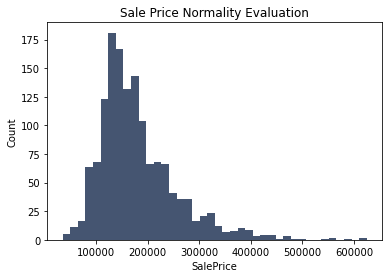

In [74]:
#Overall Saleprice distribution (Target variable should be a normally distributed variable)

sns.distplot(df['SalePrice'], kde=False, color="#172B4D", hist_kws={"alpha": 0.8})
plt.ylabel("Count")
plt.title("Sale Price Normality Evaluation")

## At this point we will not remove the outliers but would like to inform the reader regarding some discrepancy in the dataset

For our Outlier assessment, we looked at scatter plots

We saw about 5 data points that seemed "visually" as outliers. 

So we decided to investigate further. Our success was reading the "Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project" by Dean De Cock (2011). The creater of this dataset. He suggests that these 5 outliers are valid outliers and can be removed in the following process:

*Potential Pitfalls (Outliers): Although all known errors were corrected in the data, no observations have been removed due to unusual values and all final residential sales from the initial data set are included in the data presented with this article. There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.--De Cock 2021*

We found this information to be helpful. We used his input to remove the outliers accordingly.

**Note**

### We leave the outlier as is here, but implement outlier removal in subseqent round

In [75]:
df_outL=df[df["GrLivArea"] < 4000]

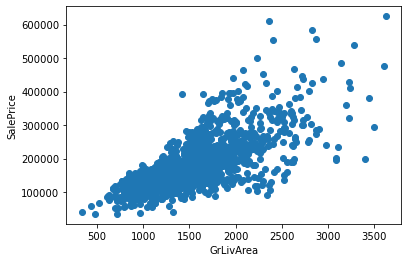

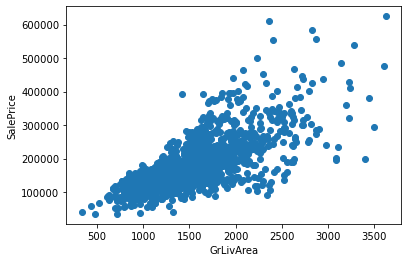

In [76]:
plt.scatter(x=df['GrLivArea'], y=df['SalePrice']);
plt.xlabel("GrLivArea"); plt.ylabel("SalePrice");
plt.show()

plt.scatter(x=df_outL['GrLivArea'], y=df_outL['SalePrice']);
plt.xlabel("GrLivArea"); plt.ylabel("SalePrice");
plt.show()

# Validating Different Regressor

Here we are training multiple regression models on the Training set and at the end we compare the results

## Base Regressor 
Using this as the base class for all regressor to share the common diagnostics like: Plotting RMSE, and other diagnostics plots

In [77]:
args.list_of_sections_to_skip=[]

In [78]:
RMSE_Scores=[]

## Linear Regression

Cached clean encoded data.
plot_predicted_vs_actual
Read clean encoded data from cache.
RMSE:29325.596201952652


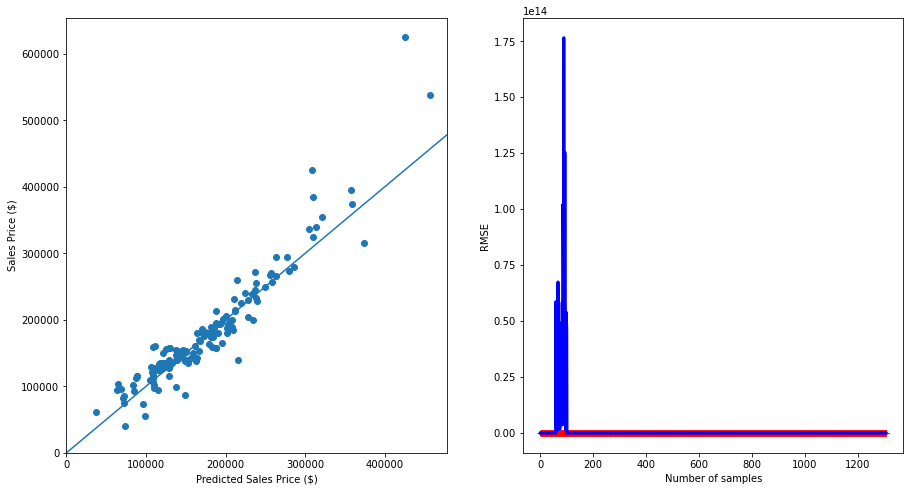

In [79]:
def analyze_linear_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    regressor = LinearRegressor()
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    
    # plot dignostics
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    BaseRegressorPlot.plot_predicted_vs_actual(axes[0], predicted, y_test)
    BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    print("RMSE:" + str(mean_squared_error(y_test, predicted, squared=False)))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)

if not 'linear' in args.list_of_sections_to_skip:
    analyze_linear_regression()

    
#print(RMSE_Scores)

## Regularized Regressions
- Rigde Regression
- Lasso Regression
- Elstic Net

## Ridge Regression
In this section we analyze Ridge regression 

Ridge is regularized version of linear regression

It adds $ \Sigma_{\ i=1}^{\ n} \ \theta_i^{\ 2}$  regularization term to cost function to keep the model weight as samll as possible.

Ridge Regression cost function:

$$ J(\theta) \ = \ MSE(\theta) + \alpha \ \frac{1}{2} \Sigma_{\ i=1}^{\ n} \ \theta_i^{\ 2} $$

Read clean encoded data from cache.
plot_predicted_vs_actual
Read clean encoded data from cache.
29406.413053315344


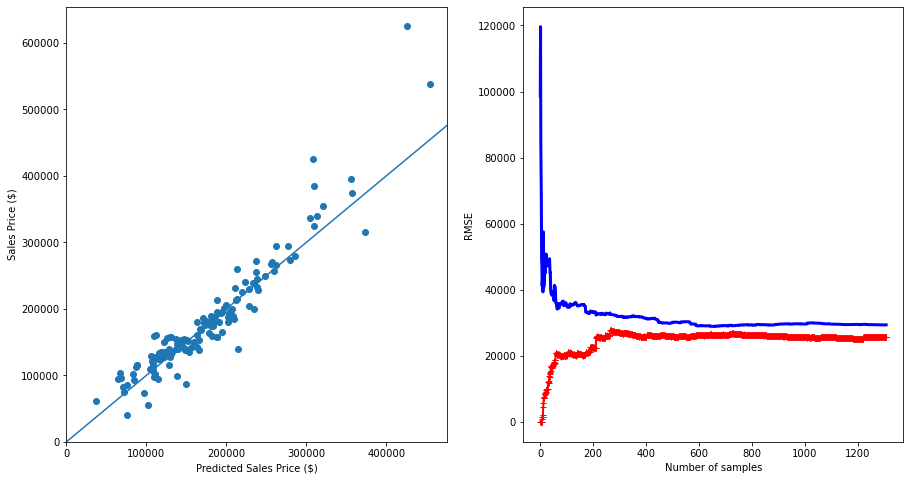

In [80]:
def analyze_ridge_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    regressor = RidgeRegressor()
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    
    # plot dignostics
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    BaseRegressorPlot.plot_predicted_vs_actual(axes[0], predicted, y_test)
    BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    #plt.scatter(y_test, regressor.predict(X_test))
    print(mean_squared_error(y_test, predicted,squared=False))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)

if not 'ridge' in args.list_of_sections_to_skip:
    analyze_ridge_regression()



## Lasso Regression

Lasso adds a regularization term to the cost function, but it uses the ℓ1 norm of the weight vector instead of half the square of the ℓ2 norm

Lasso Regression cost function

 $$ J(\theta) \ = \ MSE(\theta) + \alpha \  \Sigma_{\ i=1}^{\ n} \ |\theta_i| $$

An important characteristic of Lasso Regression is that it tends to eliminate the weights of the least important features (i.e., set them to zero).

In other words, Lasso Regression automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).

Note: Lasso regression has $\alpha$ as hyperparmeter which needs to be searched 

Read clean encoded data from cache.
plot_predicted_vs_actual
Read clean encoded data from cache.
29340.796981186755


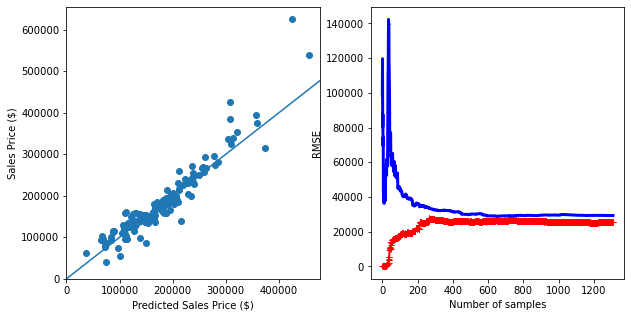

In [81]:
def analyze_lasso_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    # TODO later use search for alpha
    #regressor = LassoRegressor(alpha=0.1)
    regressor = LassoRegressor(alpha=10)
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    # plot dignostics
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    BaseRegressorPlot.plot_predicted_vs_actual(axes[0], predicted, y_test)
    BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    #plt.scatter(y_test, regressor.predict(X_test))
    print(mean_squared_error(y_test, predicted, squared=False))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)

if not 'lasso' in args.list_of_sections_to_skip:
    analyze_lasso_regression()

## Elastic Net

For Elastic Net regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio r. When r = 0, Elastic Net is equivalent to Ridge Regression, and when r = 1, it is equivalent to Lasso Regression

Elastic Net cost function

$$ J(\theta) \ = \ MSE(\theta) + r \alpha \  \Sigma_{\ i=1}^{\ n} \ |\theta_i| +  \frac{1-r}{2} \alpha \ \Sigma_{\ i=1}^{\ n} \ \theta_i^{\ 2}$$

Read clean encoded data from cache.
plot_predicted_vs_actual
Read clean encoded data from cache.
30925.94437179155


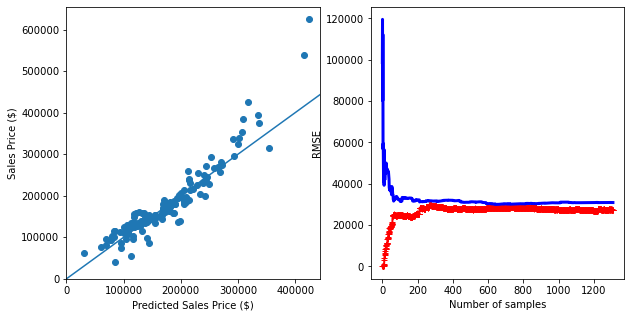

In [82]:
def analyze_elasticnet_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    # TODO later use search for alpha
    #regressor = ElasticNetRegressor(alpha=0.1, l1_ratio=0.5)
    regressor = ElasticNetRegressor(alpha=0.1, l1_ratio=0.5)
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    # plot dignostics
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    BaseRegressorPlot.plot_predicted_vs_actual(axes[0], predicted, y_test)
    BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    #plt.scatter(y_test, regressor.predict(X_test))
    print(mean_squared_error(y_test, predicted, squared=False))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)

if not 'elasticnet' in args.list_of_sections_to_skip:
    analyze_elasticnet_regression()

## Decision Tree

Read clean encoded data from cache.
plot_predicted_vs_actual
Read clean encoded data from cache.
37407.315384114045


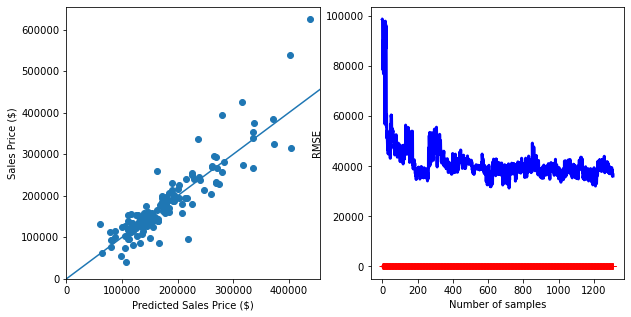

In [83]:
def analyze_decision_tree_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    regressor = DecisionTreeRegressor()
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    # plot dignostics
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    BaseRegressorPlot.plot_predicted_vs_actual(axes[0], predicted, y_test)
    BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    #plt.scatter(y_test, regressor.predict(X_test))
    print(mean_squared_error(y_test, predicted, squared=False))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)


if not 'decisontree' in args.list_of_sections_to_skip:
    analyze_decision_tree_regression()

## Random Forest

Read clean encoded data from cache.
plot_predicted_vs_actual
Read clean encoded data from cache.
30394.642471529554


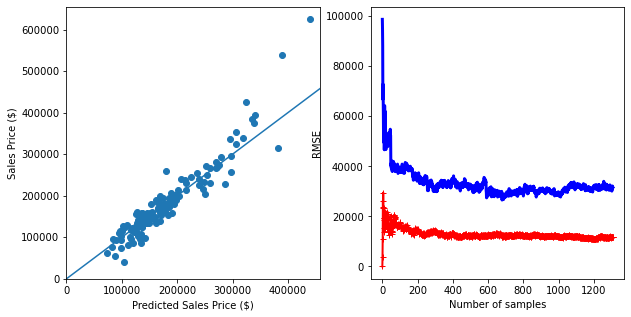

In [84]:
def analyze_random_forest_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    regressor = RandomForestRegressor()
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    # plot dignostics
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    BaseRegressorPlot.plot_predicted_vs_actual(axes[0], predicted, y_test)
    BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    #plt.scatter(y_test, regressor.predict(X_test))
    print(mean_squared_error(y_test, predicted, squared=False))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)


if not 'randomforset' in args.list_of_sections_to_skip:
    analyze_random_forest_regression()

## Wrapper method
This is a recursive feature elemination process to identify features importance

In [85]:
#reset the data to all features
df_fs_w = data_loader.df
X_train_fs_w, X_test_fs_w, y_train_fs_w, y_test_fs_w = train_test_split(
    data_loader.df_X, data_loader.df_y, test_size=0.10, random_state=1)



In [86]:
X_train = data_loader.data_prep(X_train_fs_w)
y_train = y_train_fs_w
X_test = data_loader.data_prep(X_test_fs_w)
y_test = y_test_fs_w



In [87]:

def rfe_fs(regressor, threshold=20):
    ''' Select the most important * features based on the model
         and use it as X_train & X_test'''
    selector = RFE(regressor, n_features_to_select=threshold, step=1)
    selector = selector.fit(X_train, y_train)
    selector_ind = selector.get_support()
    X_train_rfe = X_train.iloc[:, selector_ind]
    X_test_rfe = X_test.iloc[:, selector_ind]

    return X_train_rfe, X_test_rfe



In [88]:
#Initialize List to store RMSE scrores for wrapper function

RMSE_Scores_Wrapper=[]

RMSE =  37698.10661219387


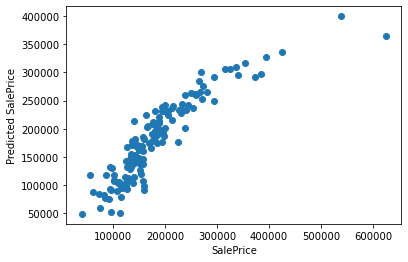

In [89]:
regressor = LinearRegression()

def analyze_regression():

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)

    # plot dignostics

    plt.scatter(y_test, regressor.predict(X_test_rfe))
    plt.xlabel("SalePrice")
    plt.ylabel("Predicted SalePrice")
    print("RMSE = ", mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)


if not 'linear' in args.list_of_sections_to_skip:
    analyze_regression()




RMSE =  37739.18820888874


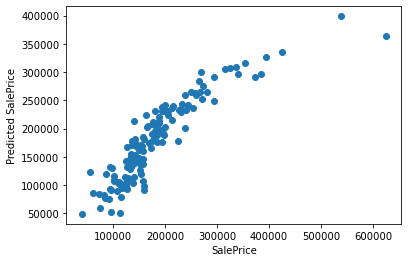

In [90]:
regressor = Ridge()


def analyze_regression():

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)

    # plot dignostics

    plt.scatter(y_test, regressor.predict(X_test_rfe))
    plt.xlabel("SalePrice")
    plt.ylabel("Predicted SalePrice")
    print("RMSE = ", mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)


if not 'ridge' in args.list_of_sections_to_skip:
    analyze_regression()



RMSE =  37698.27800160666


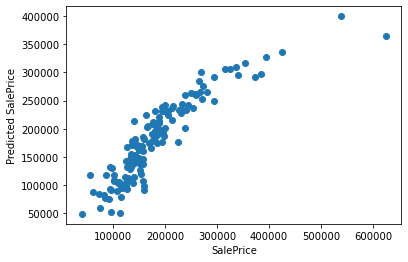

In [91]:
regressor = Lasso(alpha=0.1)

def analyze_regression():

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)

    # plot dignostics
    
    plt.scatter(y_test, regressor.predict(X_test_rfe))
    plt.xlabel("SalePrice")
    plt.ylabel("Predicted SalePrice")
    print("RMSE = ", mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)


if not 'lasso' in args.list_of_sections_to_skip:
    analyze_regression()



RMSE =  37270.44691112326


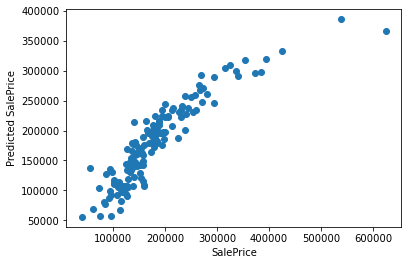

In [92]:
regressor = ElasticNet(alpha=0.1, l1_ratio=0.5)

def analyze_regression():

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)

    # plot dignostics

    plt.scatter(y_test, regressor.predict(X_test_rfe))
    plt.xlabel("SalePrice")
    plt.ylabel("Predicted SalePrice")
    print("RMSE = ",mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)


if not 'elasticnet' in args.list_of_sections_to_skip:
    analyze_regression()



RMSE =  38624.718983860475


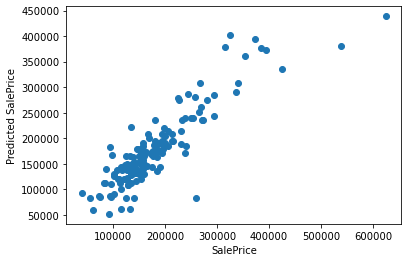

In [93]:
regressor = DTR()

def analyze_regression():
    
    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)

    # plot dignostics

    plt.scatter(y_test, regressor.predict(X_test_rfe))
    plt.xlabel("SalePrice")
    plt.ylabel("Predicted SalePrice")
    print("RMSE = ",mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)


if not 'decisontree' in args.list_of_sections_to_skip:
    analyze_regression()

RMSE =  29037.25560966653


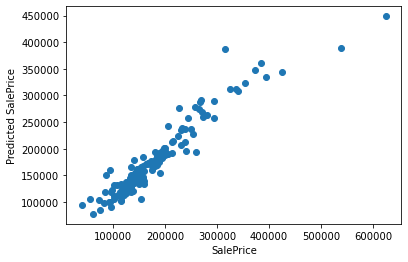

In [94]:
regressor = RFR()

def analyze_regression():

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)

    # plot dignostics

    plt.scatter(y_test, regressor.predict(X_test_rfe))
    plt.xlabel("SalePrice")
    plt.ylabel("Predicted SalePrice")
    print("RMSE = ",mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)

if not 'randomforset' in args.list_of_sections_to_skip:
    analyze_regression()



In [95]:
from sklearn.model_selection import cross_validate

## Using sklearn cross_validate, set as 5 fold (same as default)

In [96]:
def k_fold_cv(model): 
    score=cross_validate(model,X_train,y_train, cv=5, scoring="neg_mean_squared_error")['test_score']
    return score.mean()

k_fold_cv(LinearRegression()).mean()

# the model produces a metric which is  "negate MSE" so the larger the better. Since the metric is suppose
# to be used not for model selection but comparison

-758174212.8342566

In [97]:
regressor=[LinearRegression(),Ridge(),Lasso(alpha=0.1),ElasticNet(alpha=0.1, l1_ratio=0.5),DTR(),RFR()]

for model in regressor:
    score_avg=k_fold_cv(model)
    print("For {model} the average neg_mean_squared_error is {scores}".\
        format(model=model,scores=score_avg))



For LinearRegression() the average neg_mean_squared_error is -758174212.8342566
For Ridge() the average neg_mean_squared_error is -731047348.059858
For Lasso(alpha=0.1) the average neg_mean_squared_error is -757929320.7882836
For ElasticNet(alpha=0.1) the average neg_mean_squared_error is -718977868.6832272
For DecisionTreeRegressor() the average neg_mean_squared_error is -1515848007.7809157
For RandomForestRegressor() the average neg_mean_squared_error is -659000302.0228907


## Hyperparameter tuning

In [98]:
RMSE_Scores_Hyper=[]

In [99]:
X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()

def ridge_model_HP():

    parameter_space = {
        "alpha": [1, 10, 100, 290, 500],
        "fit_intercept": [True, False],
        "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    }

    clf = GridSearchCV(Ridge(random_state=3), parameter_space, n_jobs=4,
                       cv=3)

    clf.fit(X_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)
    
    ridge_model = Ridge(random_state=3, **clf.best_params_)
    ridge_model.fit(X_train, y_train);

    y_pred = ridge_model.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False))
    RMSE=mean_squared_error(y_test, y_pred, squared=False)
    RMSE_Scores_Hyper.append(RMSE)
    
ridge_model_HP()

Read clean encoded data from cache.
Best parameters:
{'alpha': 1, 'fit_intercept': False, 'solver': 'svd'}
29409.794982473635


### Hyperparamter tuning of Lasso Regressor

In [100]:
X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()

def Lasso_model_HP():

    parameter_space = {
        "alpha":[0.0001,0.0001,0.001,0.1],
    }

    clf = GridSearchCV(Lasso(), parameter_space, n_jobs=4,cv=10)

    clf.fit(X_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)

    Lasso_model = Lasso(random_state=3, **clf.best_params_)
    Lasso_model.fit(X_train, y_train);

    y_pred = Lasso_model.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False))
    RMSE=mean_squared_error(y_test, y_pred, squared=False)
    RMSE_Scores_Hyper.append(RMSE)

Lasso_model_HP()



Read clean encoded data from cache.
Best parameters:
{'alpha': 0.1}
29325.822246933545


### Hyperparameter tuning of ElasticNet

In [101]:
X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()

def Elastic_model_HP():

    parameter_space = {
        "alpha": [1, 10, 100, 280, 500],
        "l1_ratio": [0.5, 1],
        "fit_intercept": [True, False],
    }

    clf = GridSearchCV(ElasticNet(random_state=3), parameter_space, 
                       n_jobs=4, cv=3)

    clf.fit(X_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)

    elasticNet_model = ElasticNet(random_state=3, **clf.best_params_)

    elasticNet_model.fit(X_train, y_train);

    y_pred = elasticNet_model.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False))
    RMSE=mean_squared_error(y_test, y_pred, squared=False)
    RMSE_Scores_Hyper.append(RMSE)

Elastic_model_HP()

Read clean encoded data from cache.
Best parameters:
{'alpha': 10, 'fit_intercept': True, 'l1_ratio': 1}
29340.796981186755


### Hyperparameter tuning of Decision Tree Regressor

In [102]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()

def DT_model_HP():

    parameter_space =  {
            "criterion": ["mse", "friedman_mse", "mae"],
            "min_samples_split": [5, 18, 29, 50],
            "min_samples_leaf": [3, 7, 15, 25],
            "max_features": [20, 50, 150, 200, X_train.shape[1]],
        }

    clf = GridSearchCV(DecisionTreeRegressor(random_state=3), parameter_space, 
                       cv=3, n_jobs=4)

    clf.fit(X_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)

    dt_model = DecisionTreeRegressor(**clf.best_params_)

    dt_model.fit(X_train, y_train);

    y_pred = dt_model.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False))
    RMSE=mean_squared_error(y_test, y_pred, squared=False)
    RMSE_Scores_Hyper.append(RMSE)

DT_model_HP()

Read clean encoded data from cache.
Best parameters:
{'criterion': 'mse', 'max_features': 60, 'min_samples_leaf': 7, 'min_samples_split': 18}
35942.875201619725


### Hyperparameter tuning of Random Forest Regressor

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()

def RandomForest_model_HP():

    parameter_space = \
        {
            "n_estimators": [10, 100, 300, 600],
            "criterion": ["mse", "mae"],
            "max_depth": [7, 50, 254],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 5],
            "max_features": [19, 100, X_train.shape[1]],
            "bootstrap": [True, False],
        }

    clf = RandomizedSearchCV(RandomForestRegressor(random_state=3), 
                             parameter_space, cv=3, n_jobs=4, 
                             n_iter=10, random_state=3)

    clf.fit(X_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)

    rf_model = RandomForestRegressor(**clf.best_params_)

    rf_model.fit(X_train, y_train);

    y_pred = rf_model.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False))
    RMSE=mean_squared_error(y_test, y_pred, squared=False)
    RMSE_Scores_Hyper.append(RMSE)

RandomForest_model_HP()

Read clean encoded data from cache.
Best parameters:
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 19, 'max_depth': 254, 'criterion': 'mse', 'bootstrap': False}
30078.523008463828


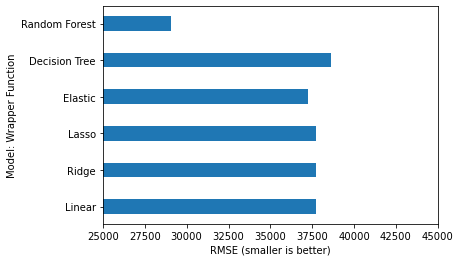

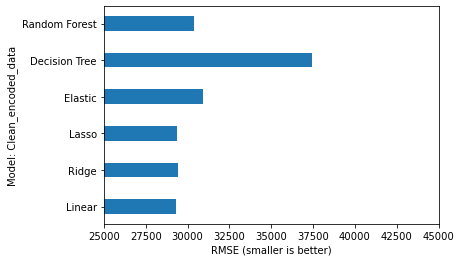

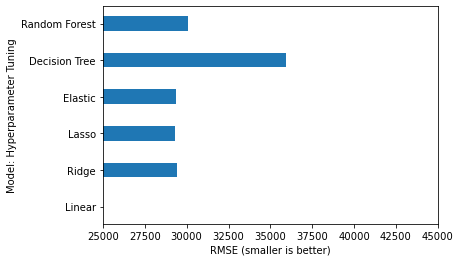

In [106]:
x2 = ['Linear','Ridge','Lasso','Elastic','Decision Tree','Random Forest']
y = RMSE_Scores_Wrapper[:6]

fig, ax = plt.subplots()
plt.barh(y=range(len(x2)), tick_label=x2, width=y, height=0.4);
plt.xlim(25000,45000)
ax.set(xlabel="RMSE (smaller is better)", ylabel="Model: Wrapper Function");

x1 = ['Linear','Ridge','Lasso','Elastic','Decision Tree','Random Forest']
y = RMSE_Scores[:6]

fig, ax = plt.subplots()
plt.barh(y=range(len(x1)), tick_label=x1, width=y, height=0.4);
plt.xlim(25000,45000)
ax.set(xlabel="RMSE (smaller is better)", ylabel="Model: Clean_encoded_data");


RMSE_Scores_Hyper.insert(0,0)
x3 = ['Linear','Ridge','Lasso','Elastic','Decision Tree','Random Forest']
y = RMSE_Scores_Hyper[-6:]

fig, ax = plt.subplots()
plt.barh(y=range(len(x3)), tick_label=x3, width=y, height=0.4);
plt.xlim(25000,45000)
ax.set(xlabel="RMSE (smaller is better)", ylabel="Model: Hyperparameter Tuning");

In [107]:
df = pd.DataFrame({
            'Regressor': x1,
            'Wrapper':RMSE_Scores_Wrapper[:6],
            'Baseline': RMSE_Scores[:6],
            'Hyperparameter_tuning':RMSE_Scores_Hyper[-6:]
            })
df = df.style.set_caption('Comparison of RMSE Scores for various Regressors with, Baseline, Wrapper Function and Hyperparameter tuning')
display(df)

,Regressor,Wrapper,Baseline,Hyperparameter_tuning
0,Linear,37698.106612,29325.596202,0.000000
1,Ridge,37739.188209,29406.413053,29409.794982
2,Lasso,37698.278002,29340.796981,29325.822247
3,Elastic,37270.446911,30925.944372,29340.796981
4,Decision Tree,38624.718984,37407.315384,35942.875202
5,Random Forest,29037.255610,30394.642472,30078.523008
